In [1]:
import pandas as pd
import json
import pickle
from collections import Counter
from collections import OrderedDict
from operator import itemgetter
from tqdm import tqdm_notebook
import json
import matplotlib.pyplot as plt
import powerlaw
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
with open('data/RT_and_QT_info.json', 'r') as fp:
    RT_and_QT_info = json.load(fp)

In [3]:
with open('data/hashtag_id_map.json', 'r') as fp:
    hashtag_id_map = json.load(fp)

In [4]:
df = pd.read_pickle('data/tweet_data.p')

In [5]:
hashtags = []
count_of_hashtags = []

for tag,ids in hashtag_id_map.items():
    hashtags.append(tag)
    count_of_hashtags.append(len(ids))

In [6]:
len(hashtags),len(count_of_hashtags)

(8515, 8515)

In [7]:
count_of_hashtags, hashtags = zip(*sorted(zip(count_of_hashtags, hashtags)))

In [8]:
hashtags[-5:]

('PhirEkBaarModiSarkar',
 'Elections2019',
 'Congress',
 'MainBhiChowkidar',
 'LokSabhaElections2019')

In [9]:
number_to_extract = len(count_of_hashtags)-sum([count_of_hashtags.count(i) for i in range(10)])

## CTM helper functions

In [10]:
def get_RT_traffic_all(tag,K):
    total_RT =  0
    K['sum'] = K['adjusted_RT'] + K['adjusted_QT']
    total_RT += K['sum'].sum()
    return total_RT

In [11]:
def get_RT_traffic_dataset(tag):
    total_RT = 0
    for i in hashtag_id_map[tag]:
        total_RT+=RT_and_QT_info[repr(i)]['retweet_count_added']
        total_RT+=RT_and_QT_info[repr(i)]['quoted_count_added']
    return total_RT

In [12]:
def get_total_traffic(tag,RT_traffic):
    return len(hashtag_id_map[tag])+RT_traffic

In [13]:
def get_total_users_for_tag(tag,K):
    user_ids = []
    user_ids.extend(K['user_id'])
    for i in K['tweet_id']:
        user_ids.extend([j[0] for j in RT_and_QT_info[repr(i)]['retweet_user_info'].values()])
        user_ids.extend([j[0] for j in RT_and_QT_info[repr(i)]['quoted_user_info'].values()])
    return user_ids

In [14]:
def get_percentage_traffic_by_active_users(users,total_traffic):
    if len(set(users))<50:
        return 1
    else:
        count_of_each_user = Counter(users)
        sorted_dict = sorted(count_of_each_user.items(), key = itemgetter(1), reverse = True)
        traffic_of_active_users = 0
        for i,j in sorted_dict[:50]:
            traffic_of_active_users+=j

        return float(traffic_of_active_users)/total_traffic

In [15]:
def get_required_values(tag):
    K = df[df.tweet_id.isin(hashtag_id_map[tag])]
    RT_total_traffic = get_RT_traffic_dataset(tag)
#     RT_total_traffic = get_RT_traffic_all(tag,K)
    total_traffic = get_total_traffic(tag,RT_total_traffic)
    users = get_total_users_for_tag(tag,K)
    
    # Avg tweet per user
    avg_tweet_per_user = float(total_traffic)/len(set(users))
    
    # proportion of RT 
    proportion_of_RT = (float(RT_total_traffic)/total_traffic)*100
    
    # proportion of traffic produced by 50 most active users
    proportion_of_traffic_by_active_users = get_percentage_traffic_by_active_users(users,total_traffic)*100
    
    return avg_tweet_per_user, proportion_of_RT, proportion_of_traffic_by_active_users

In [16]:
def calculate_ctm(avg_tweet_per_user, proportion_of_RT, proportion_of_traffic_by_active_users):
    return avg_tweet_per_user + proportion_of_traffic_by_active_users + (proportion_of_RT/10.0)

In [17]:
hashtag_CTM = dict()

In [18]:
for tag in tqdm_notebook(hashtags[::-1][:number_to_extract]):
    avg_tweet_per_user, proportion_of_RT, proportion_of_traffic_by_active_users = get_required_values(tag)
    ctm = calculate_ctm(avg_tweet_per_user, proportion_of_RT, proportion_of_traffic_by_active_users)
    hashtag_CTM[tag] = {'avg_tweet_per_user':avg_tweet_per_user,
                     'proportion_of_RT':proportion_of_RT,
                     'proportion_of_traffic_by_active_users':proportion_of_traffic_by_active_users,
                     'ctm':ctm
                    }

/home/hitkul/anaconda3/envs/PSOSM/lib/python3.6/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


## Analysis - total number of post by each user

In [20]:
def get_all_users():
    all_users = []
    all_users.extend(df['user_id'])
    for i in df['tweet_id']:
        all_users.extend([j[0] for j in RT_and_QT_info[repr(i)]['retweet_user_info'].values()])
        all_users.extend([j[0] for j in RT_and_QT_info[repr(i)]['quoted_user_info'].values()])
    return all_users

In [21]:
all_users = get_all_users()

In [22]:
len(all_users)

56927

In [23]:
len(set(all_users))

41554

In [24]:
count_of_all_user = Counter(all_users)

In [25]:
count_of_all_user_sorted =sorted(count_of_all_user.items(), key = itemgetter(1), reverse = True)

In [26]:
for j in count_of_all_user_sorted[:10]:
    print(j)

(1030395105713111040, 57)
(1036498916374659079, 56)
(995228712067973121, 42)
(1026523922219638784, 23)
(2307712298, 19)
(736533261145382914, 19)
(762477085814198273, 18)
(42606652, 17)
(1013725556913786880, 17)
(4088567898, 17)


In [27]:
count_value_of_all_users = [i[1] for i in count_of_all_user_sorted]

(array([4.1247e+04, 2.7400e+02, 2.6000e+01, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([ 1. ,  6.6, 12.2, 17.8, 23.4, 29. , 34.6, 40.2, 45.8, 51.4, 57. ]),
 <a list of 10 Patch objects>)

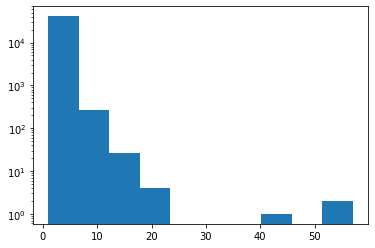

In [28]:
plt.hist(count_value_of_all_users,log=True)

In [29]:
def fit_powerlaw(seq):
    fit = powerlaw.Fit(pd.np.array(seq)+1,xmin=1,discrete=True)
    fit.power_law.plot_pdf( color= 'b',linestyle='--',label='fit ccdf')
    fit.plot_pdf( color= 'b')

    print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

/home/hitkul/anaconda3/envs/PSOSM/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


alpha=  1.6643184024023632   sigma=  0.0032588912286984593


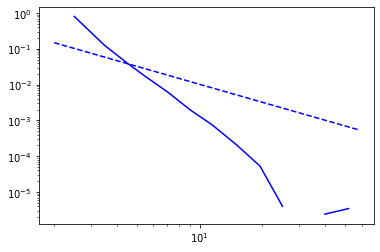

In [30]:
fit_powerlaw(count_value_of_all_users)

## Analysis - Values for CTM

In [31]:
avg_tweet_per_user_list=[]
proportion_of_RT_list=[]
proportion_of_traffic_by_active_users_list=[]
ctm_list=[]

In [32]:
for tag_,values_ in hashtag_CTM.items():
    avg_tweet_per_user_list.append(values_['avg_tweet_per_user'])
    proportion_of_RT_list.append(values_['proportion_of_RT'])
    proportion_of_traffic_by_active_users_list.append(values_['proportion_of_traffic_by_active_users'])
    ctm_list.append(values_['ctm'])

In [33]:
len(avg_tweet_per_user_list),len(proportion_of_RT_list),len(proportion_of_traffic_by_active_users_list),len(ctm_list)

(321, 321, 321, 321)

### Average tweet per user

In [34]:
max(avg_tweet_per_user_list)

8.307692307692308

(array([310.,   4.,   5.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([1.        , 1.73076923, 2.46153846, 3.19230769, 3.92307692,
        4.65384615, 5.38461538, 6.11538462, 6.84615385, 7.57692308,
        8.30769231]),
 <a list of 10 Patch objects>)

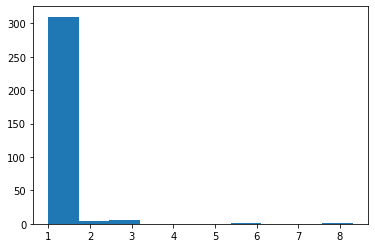

In [35]:
plt.hist(avg_tweet_per_user_list)

(array([310.,   4.,   5.,   0.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([1.        , 1.73076923, 2.46153846, 3.19230769, 3.92307692,
        4.65384615, 5.38461538, 6.11538462, 6.84615385, 7.57692308,
        8.30769231]),
 <a list of 10 Patch objects>)

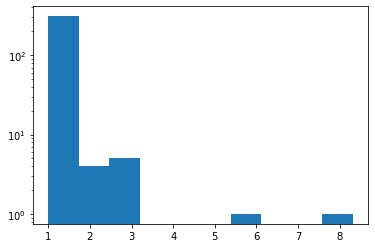

In [36]:
plt.hist(avg_tweet_per_user_list, log=True)

/home/hitkul/anaconda3/envs/PSOSM/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


alpha=  1.6907047423677775   sigma=  0.038551379364041065


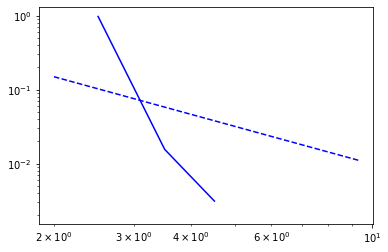

In [37]:
fit_powerlaw(avg_tweet_per_user_list)

### Proportion of RT as traffic

In [2]:
max(proportion_of_RT_list)

NameError: name 'proportion_of_RT_list' is not defined

In [1]:
plt.hist(proportion_of_RT_list,bins='fd')

NameError: name 'plt' is not defined

### Proportion of traffic by active users

In [40]:
max(proportion_of_traffic_by_active_users_list)

100

(array([ 34.,  22.,  20.,  32.,  16.,  27., 170.]),
 array([  3.08030803,  16.92597831,  30.77164859,  44.61731887,
         58.46298916,  72.30865944,  86.15432972, 100.        ]),
 <a list of 7 Patch objects>)

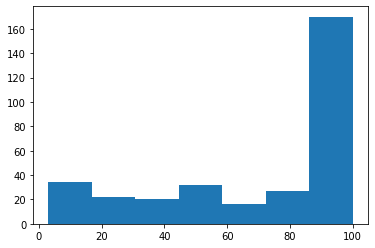

In [41]:
plt.hist(proportion_of_traffic_by_active_users_list,bins='fd')

### CTM

In [42]:
max(ctm_list),min(ctm_list)

(116.82621082621083, 13.637066557667415)

(array([ 28.,  22.,  14.,  15.,  25.,  16.,  14.,  18., 124.,  45.]),
 array([ 13.63706656,  23.95598098,  34.27489541,  44.59380984,
         54.91272427,  65.23163869,  75.55055312,  85.86946755,
         96.18838197, 106.5072964 , 116.82621083]),
 <a list of 10 Patch objects>)

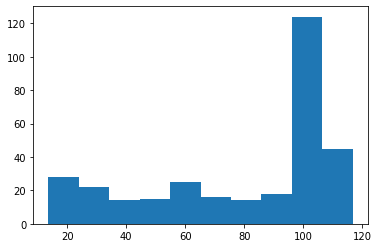

In [43]:
plt.hist(ctm_list)

(array([ 28.,  22.,  14.,  15.,  25.,  16.,  14.,  18., 124.,  45.]),
 array([ 13.63706656,  23.95598098,  34.27489541,  44.59380984,
         54.91272427,  65.23163869,  75.55055312,  85.86946755,
         96.18838197, 106.5072964 , 116.82621083]),
 <a list of 10 Patch objects>)

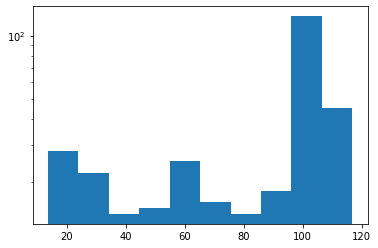

In [44]:
plt.hist(ctm_list,log=True)

/home/hitkul/anaconda3/envs/PSOSM/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


alpha=  1.2014935436242653   sigma=  0.011246272919793975


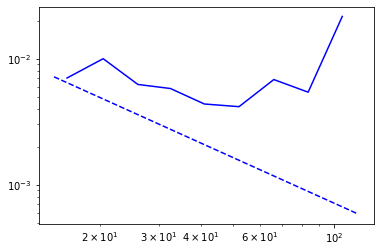

In [45]:
fit_powerlaw(ctm_list)